In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stumpy
from pathlib import Path

plt.rcParams["figure.figsize"] = (14, 4)

DATA_DIR = Path("../../data/bee_anomaly")  # adjust to your folder

HIVE_FILES = {
    "Hive_A": DATA_DIR / "Hive17.csv",
    "Hive_B": DATA_DIR / "Hive36.csv",
    "Hive_C": DATA_DIR / "Hive85.csv",
}


def load_hive(path: Path) -> pd.DataFrame:
    """
    Expected columns (semicolon separator):
    Hour;DateTime;T17;RH17;AT17;Tamb;RHamb;ATamb;T17-Tamb;AT17-ATamb
    """
    df = pd.read_csv(path, sep=";")
    df["DateTime"] = pd.to_datetime(df["DateTime"], dayfirst=True)
    df = df.sort_values("DateTime")
    df = df.set_index("DateTime")

    # ensure numeric
    num_cols = [
        "T",
        "RH",
        "AT",
        "Tamb",
        "RHamb",
        "ATamb",
        "T-Tamb",
        "AT-ATamb",
    ]
    for c in num_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=num_cols)

    return df


hives = {name: load_hive(path) for name, path in HIVE_FILES.items()}
hives


{'Hive_A':                      Hour     T  RH    AT  Tamb  RHamb  ATamb  T-Tamb  \
 DateTime                                                                
 2021-08-21 14:00:00     1  32.8  47  36.6  28.8     33   29.1     4.0   
 2021-08-21 15:00:00     2  33.3  46  37.1  28.8     36   29.5     4.5   
 2021-08-21 16:00:00     3  33.5  46  37.4  28.9     35   29.5     4.6   
 2021-08-21 17:00:00     4  33.8  49  38.5  28.5     36   29.1     5.3   
 2021-08-21 18:00:00     5  33.8  51  38.8  27.5     40   28.4     6.3   
 ...                   ...   ...  ..   ...   ...    ...    ...     ...   
 2021-11-06 08:00:00  1843  15.9  77  16.5  13.1    100   14.1     2.8   
 2021-11-06 09:00:00  1844  16.3  77  17.0  15.3     87   16.3     1.0   
 2021-11-06 10:00:00  1845  17.2  79  18.3  18.9     68   19.8    -1.7   
 2021-11-06 11:00:00  1846  19.4  81  21.4  21.5     56   22.2    -2.1   
 2021-11-06 12:00:00  1847  22.6  83  26.2  23.6     49   24.3    -1.0   
 
                      AT-A

In [4]:
def matrix_profile_anomaly_plot(
    ts: np.ndarray,
    name: str,
    m: int = 50,
    k_motifs: int = 2,
    k_discords: int = 3,
    n_regimes: int = 3,
):
    """
    ts: 1D numpy array
    m: subsequence length
    Visualizes motifs, discords, matrix profile and regime changes.
    """

    ts = np.asarray(ts, dtype="float64")
    mp = stumpy.stump(ts, m=m)
    mp_values = mp[:, 0]
    mp_indices = mp[:, 1].astype(np.int64)

    # motifs (smallest MP values)
    motif_starts = np.argsort(mp_values)[:k_motifs]
    motif_pairs = [mp_indices[i] for i in motif_starts]

    # discords (largest MP values)
    discord_starts = np.argsort(mp_values)[-k_discords:]

    # regime changes via FLUSS
    L = 4 * m
    cac, regime_locs = stumpy.fluss(mp_indices, L, n_regimes)

    fig, axs = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

    # 1) time series + motifs
    axs[0].plot(ts, linewidth=0.8)
    for s, p in zip(motif_starts, motif_pairs):
        axs[0].axvspan(s, s + m, alpha=0.3, color="tab:blue")
        axs[0].axvspan(p, p + m, alpha=0.3, color="tab:orange")
    axs[0].set_title(f"{name} – motifs (repeated subsequences)")

    # 2) time series + discords
    axs[1].plot(ts, linewidth=0.8)
    for s in discord_starts:
        axs[1].axvspan(s, s + m, alpha=0.3, color="tab:red")
    axs[1].set_title(f"{name} – discords (anomalous subsequences)")

    # 3) matrix profile
    axs[2].plot(mp_values, linewidth=0.8)
    axs[2].scatter(motif_starts, mp_values[motif_starts], s=40, label="motifs")
    axs[2].scatter(discord_starts, mp_values[discord_starts], s=40, label="discords")
    axs[2].set_ylabel("MP value")
    axs[2].set_title(f"{name} – matrix profile")
    axs[2].legend()

    # 4) FLUSS regime changes
    axs[3].plot(cac, linewidth=0.8)
    for loc in regime_locs:
        axs[3].axvline(loc, linestyle="--")
    axs[3].set_title(f"{name} – regime changes (FLUSS minima)")
    axs[3].set_xlabel("Index")

    plt.tight_layout()
    plt.show()


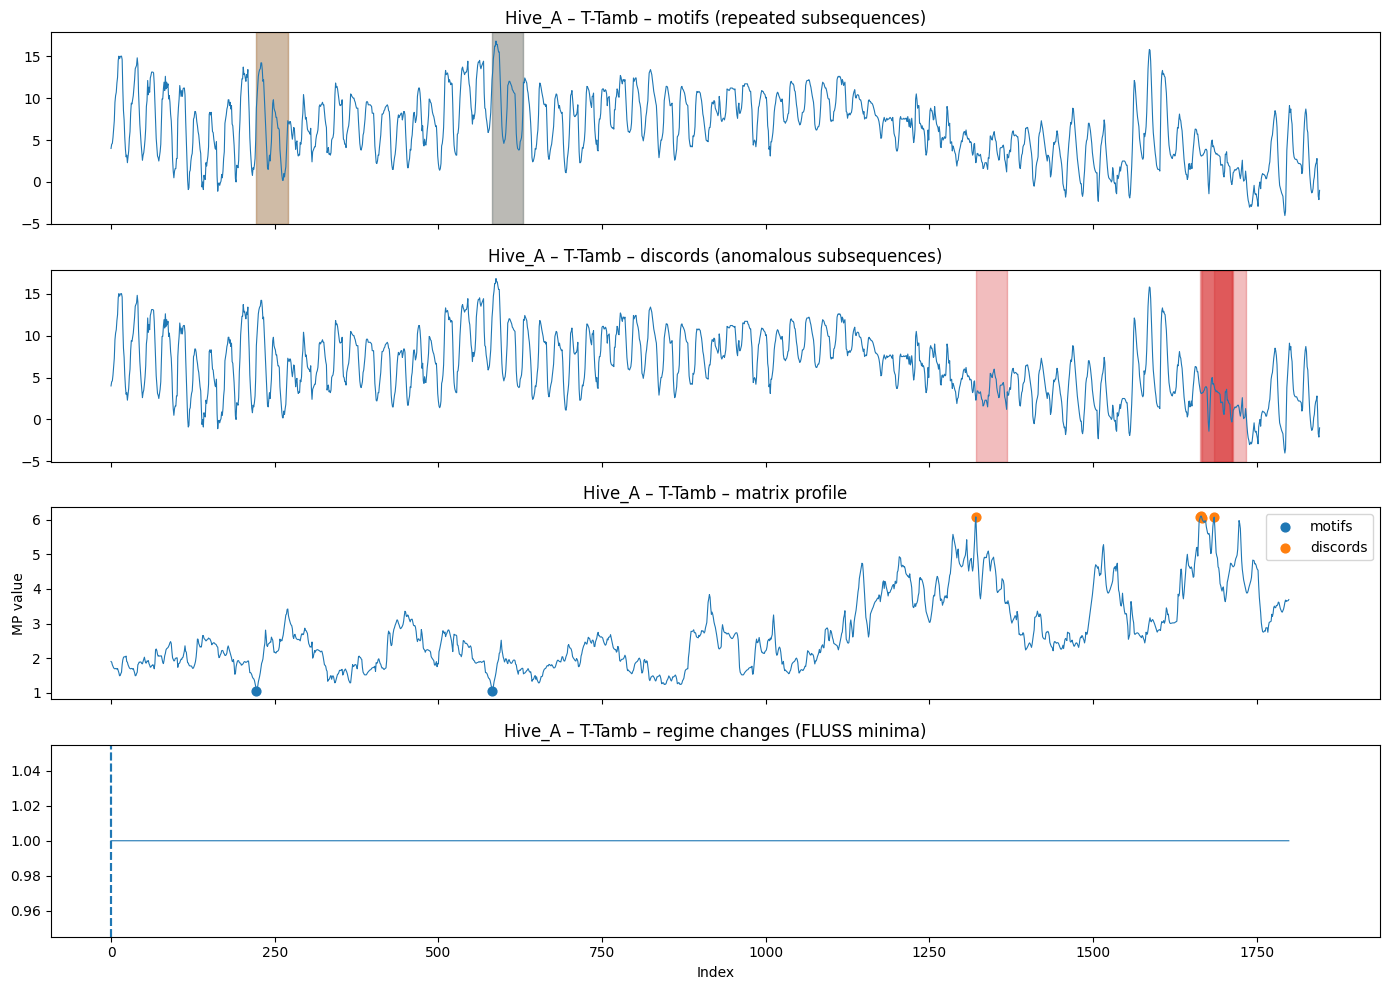

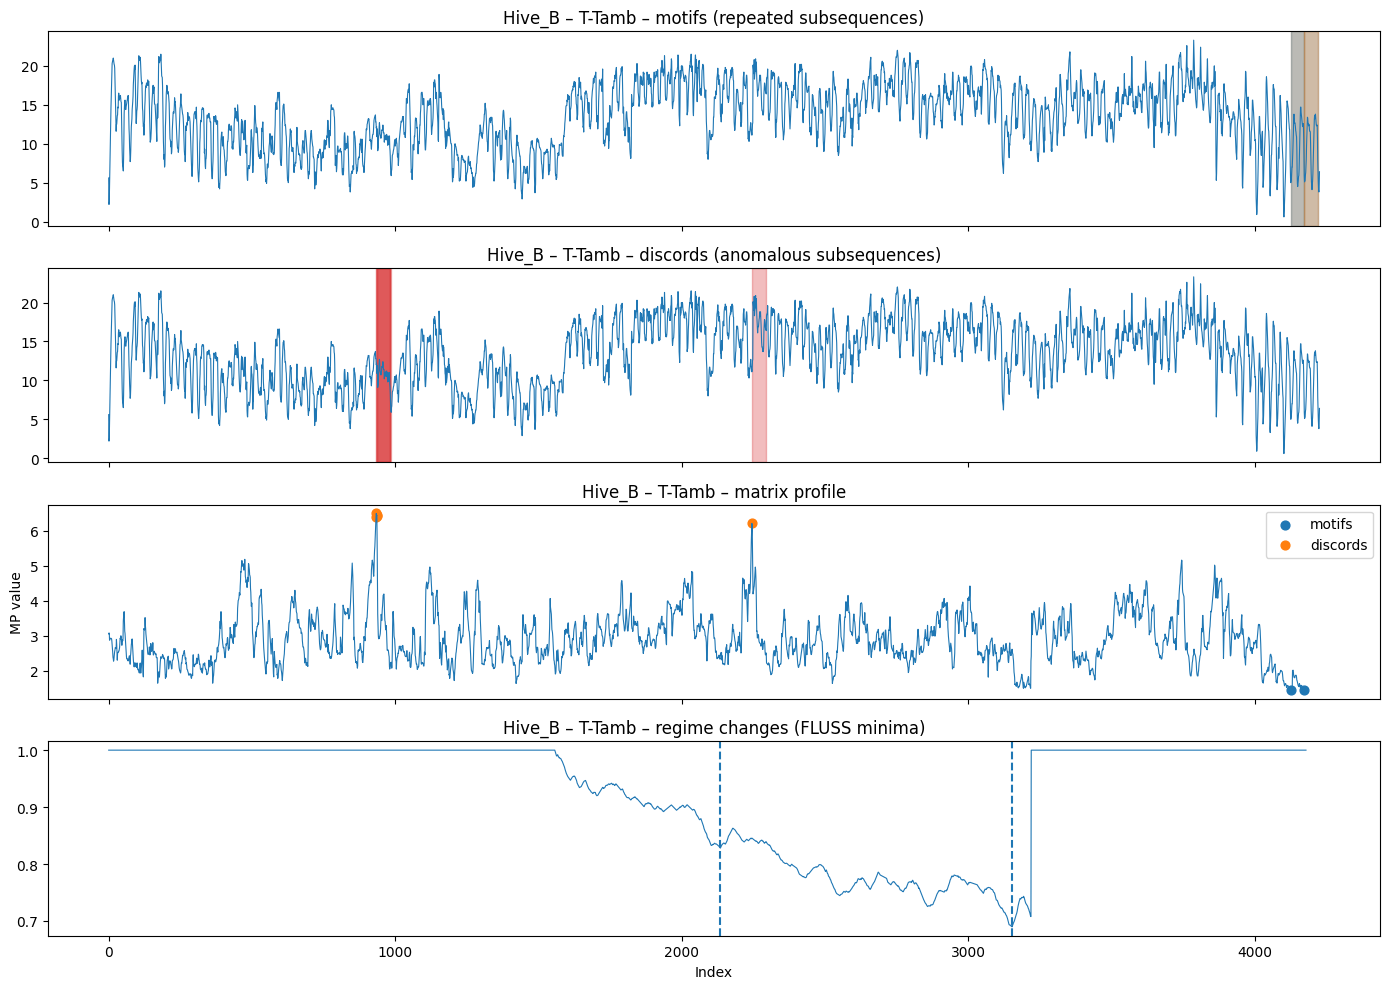

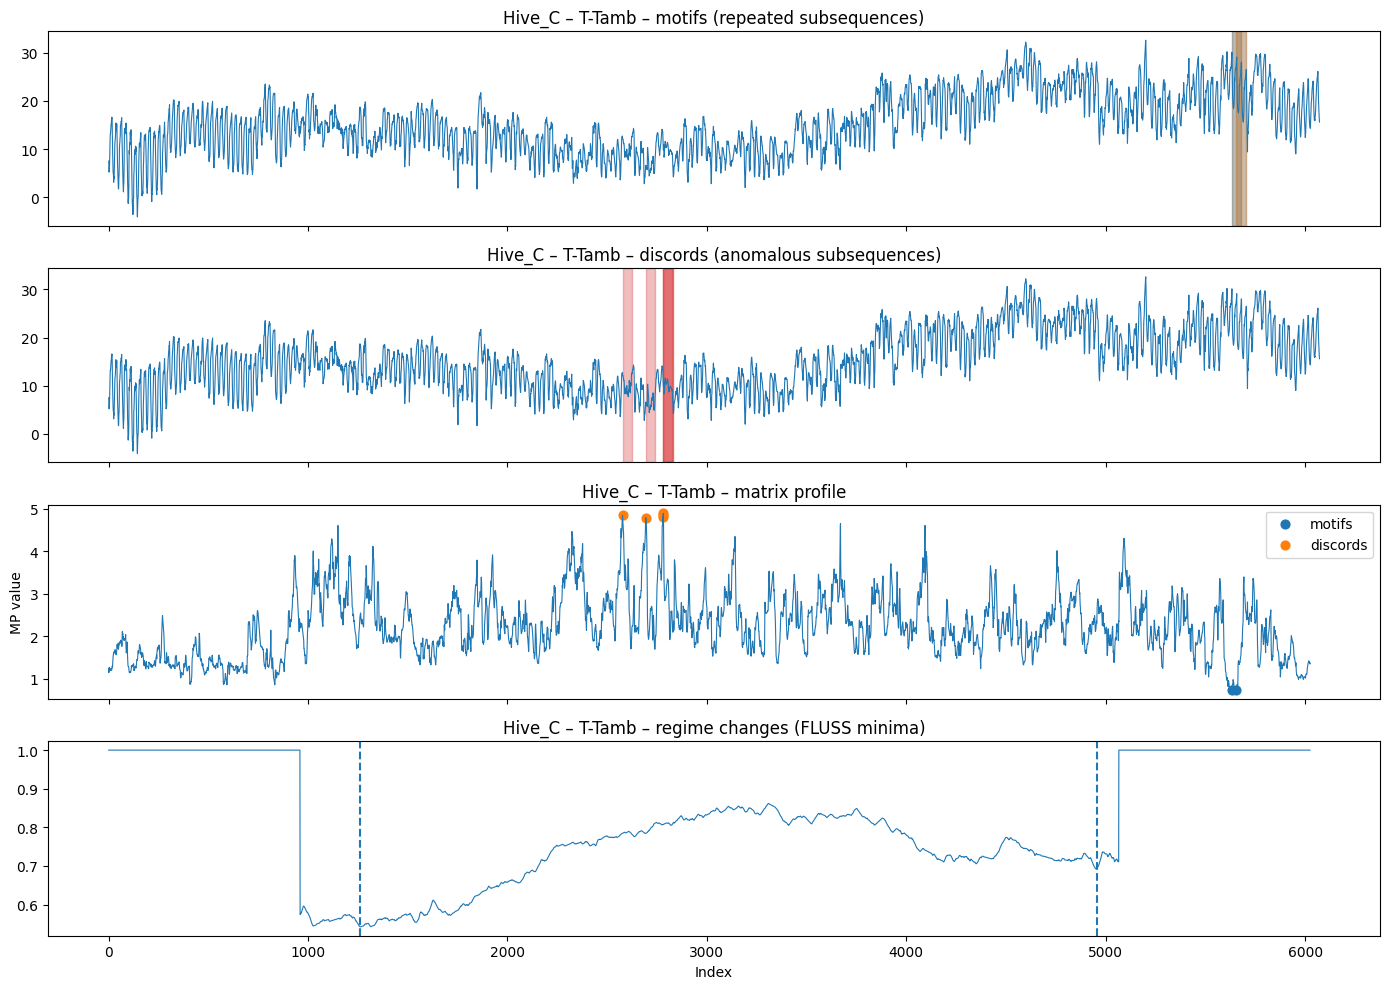

In [5]:
def inspect_hive_signal(
    hives: dict[str, pd.DataFrame],
    signal_col: str = "T-Tamb",
    m: int = 50,
    k_discords: int = 3,
):
    """
    For each hive, plot matrix-profile-based anomalies for the given signal.
    """
    for hive_name, df in hives.items():
        ts = df[signal_col].values
        matrix_profile_anomaly_plot(
            ts,
            name=f"{hive_name} – {signal_col}",
            m=m,
            k_motifs=2,
            k_discords=k_discords,
            n_regimes=3,
        )

inspect_hive_signal(hives, signal_col="T-Tamb", m=48, k_discords=5)


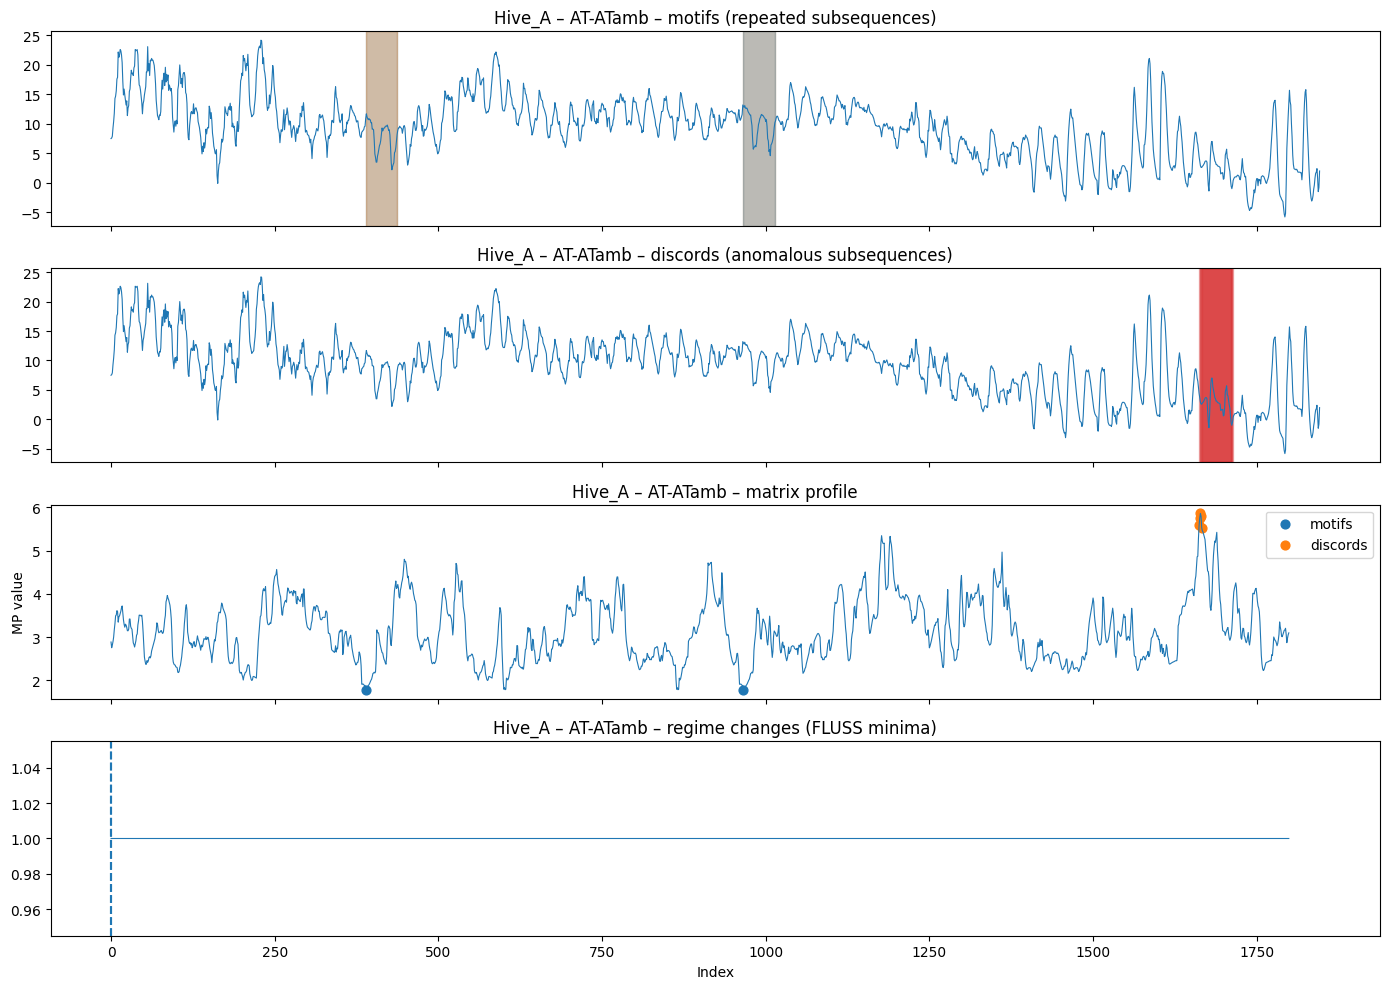

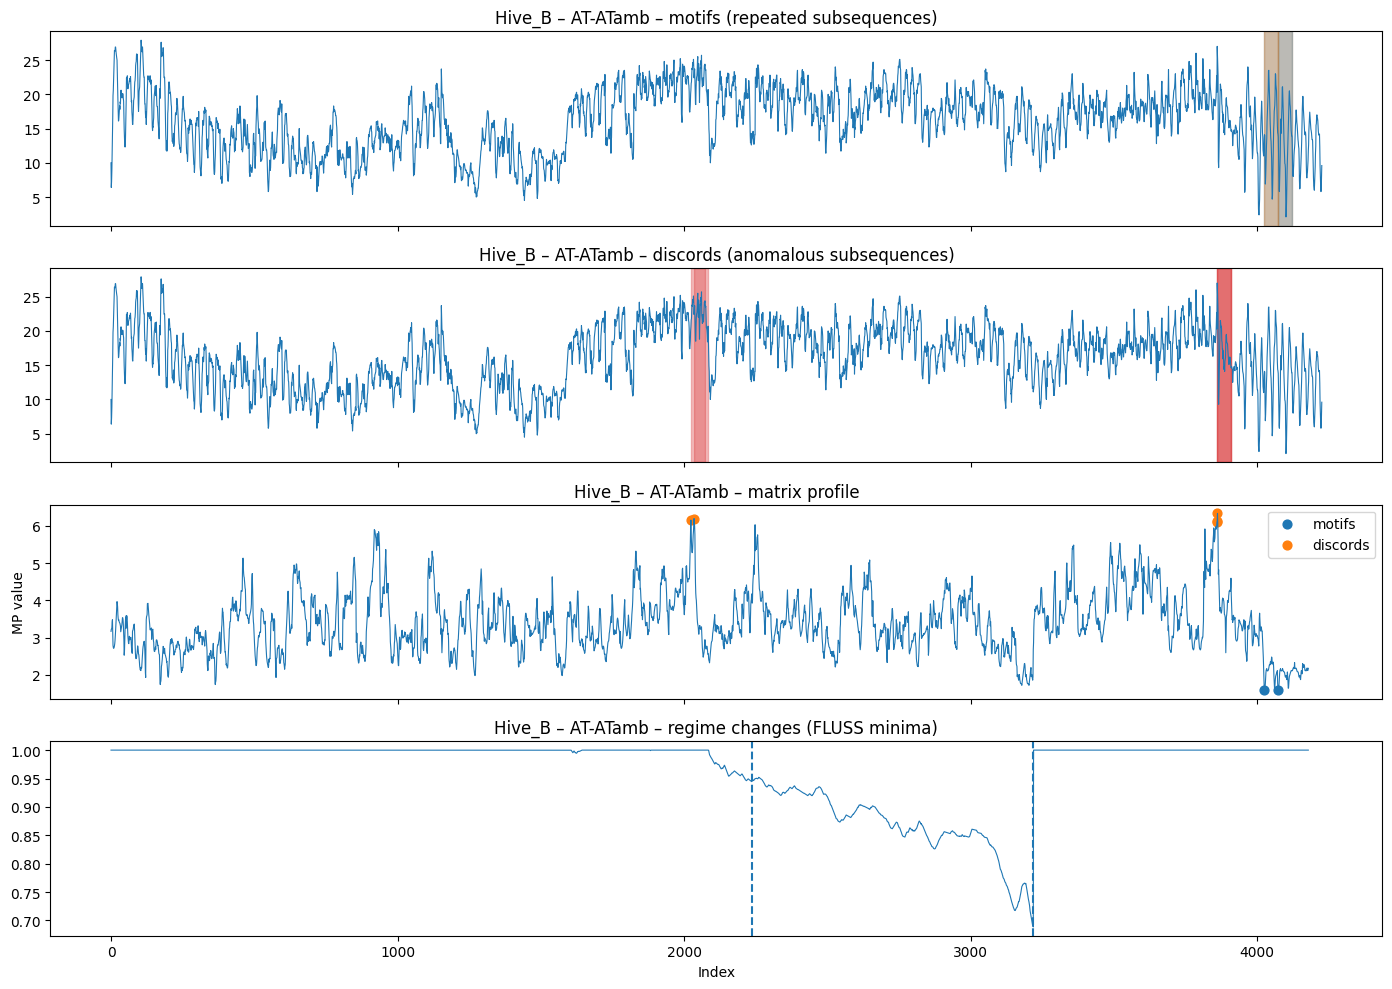

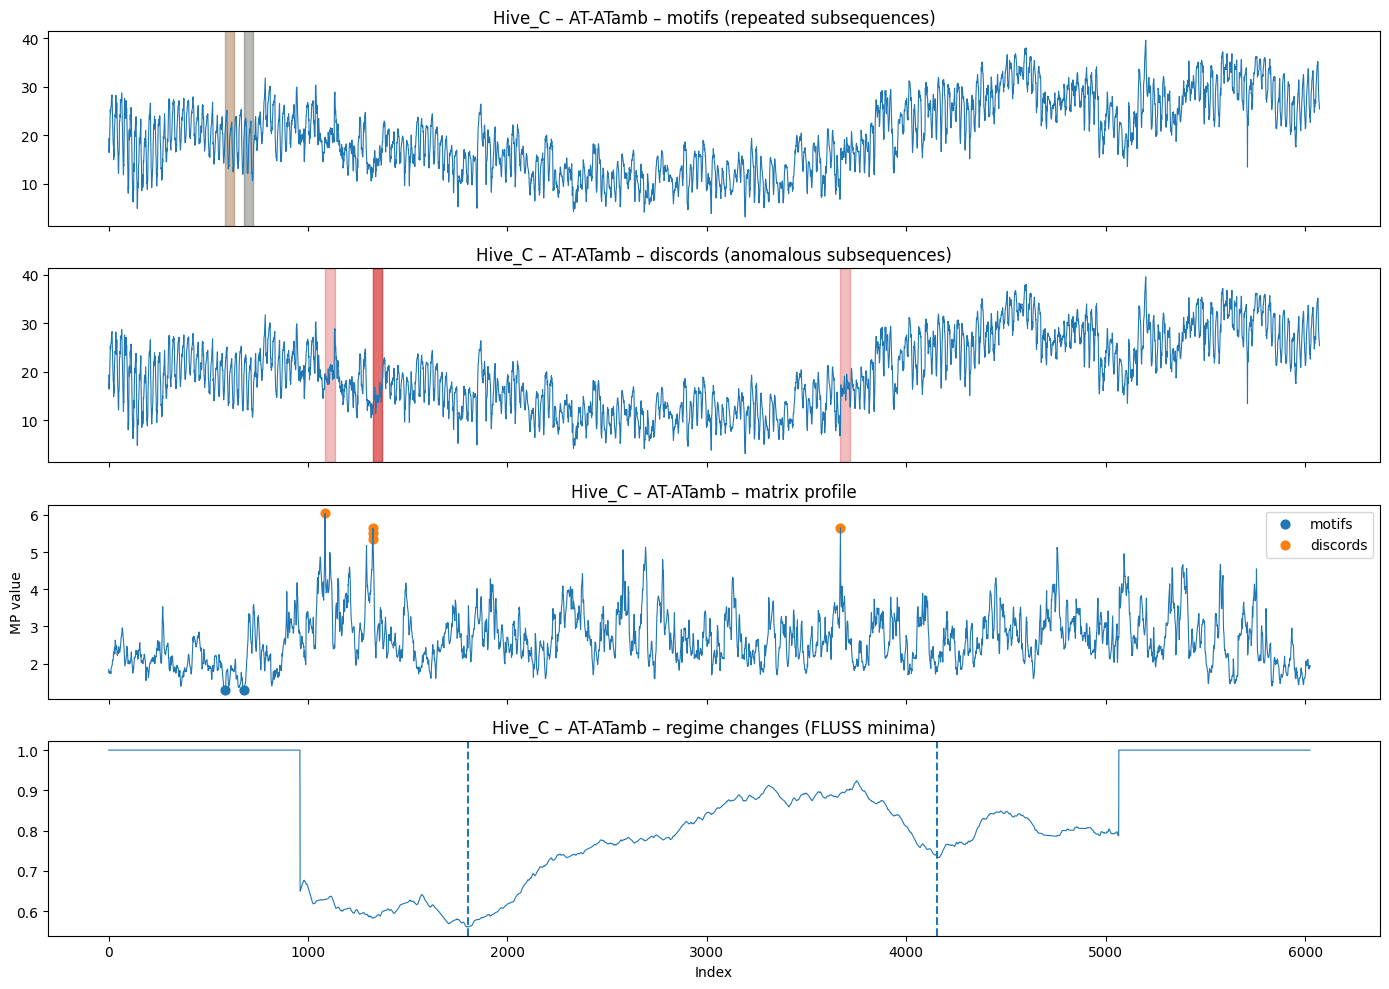

In [4]:
inspect_hive_signal(hives, signal_col="AT-ATamb", m=48, k_discords=5)

In [14]:
# CELL: multiple aeon detectors on bee hives

import numpy as np
import matplotlib.pyplot as plt

from aeon.anomaly_detection.series.distance_based import (
    STOMP,          # matrix-profile based, returns scores
    LOF,            # Local Outlier Factor wrapper, returns score
)

from aeon.anomaly_detection.series.distribution_based import COPOD, DWT_MLEAD
from aeon.anomaly_detection.series.outlier_detection import IsolationForest, OneClassSVM, STRAY

def run_aeon_detector_on_hive(
    name: str,
    df: pd.DataFrame,
    col: str,
    detector,
    top_k: int = 30,
):
    """
    Generic runner for aeon series anomaly detectors.

    - name: hive name ("Hive_A", ...)
    - df: DataFrame for that hive
    - col: column to analyze, e.g. "T", "T-Tamb"
    - detector: instantiated aeon detector (e.g. STOMP(...))
    - top_k: how many most anomalous points to highlight if detector returns scores
    """
    ts = df[col].to_numpy().astype(float)
    idx = df.index.to_numpy()

    out = detector.fit_predict(ts)  # can be scores or binary labels
    out = np.asarray(out)

    # if detector returns bool/int 0/1 → treat as labels and fake scores
    if out.dtype == bool or np.array_equal(np.unique(out), [0]) or np.array_equal(np.unique(out), [1]) \
       or np.array_equal(np.unique(out), [0, 1]):
        labels = out.astype(int)
        scores = labels.astype(float)
    else:
        scores = out.astype(float)
        # derive labels: top_k highest scores as anomalies
        k = min(top_k, len(scores))
        thresh = np.partition(scores, -k)[-k]
        labels = (scores >= thresh).astype(int)

    anom_idx = np.where(labels == 1)[0]

    fig, axs = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

    # 1) time series with anomalies
    axs[0].plot(idx, ts, linewidth=0.8, label=col)
    if len(anom_idx) > 0:
        axs[0].scatter(
            idx[anom_idx],
            ts[anom_idx],
            color="red",
            s=20,
            label="Anomalies",
            zorder=3,
        )
    axs[0].set_title(f"{name} – {col} – {detector.__class__.__name__}")
    axs[0].set_ylabel(col)
    axs[0].legend(loc="upper right")

    # 2) anomaly scores / labels
    axs[1].plot(idx, scores, linewidth=0.8, label="score (higher = more anomalous)")
    if len(anom_idx) > 0:
        axs[1].scatter(
            idx[anom_idx],
            scores[anom_idx],
            color="red",
            s=20,
            label="Anomalies",
            zorder=3,
        )
    axs[1].set_ylabel("score / label")
    axs[1].set_xlabel("time")
    axs[1].legend(loc="upper right")

    plt.tight_layout()
    plt.show()

    return scores, labels

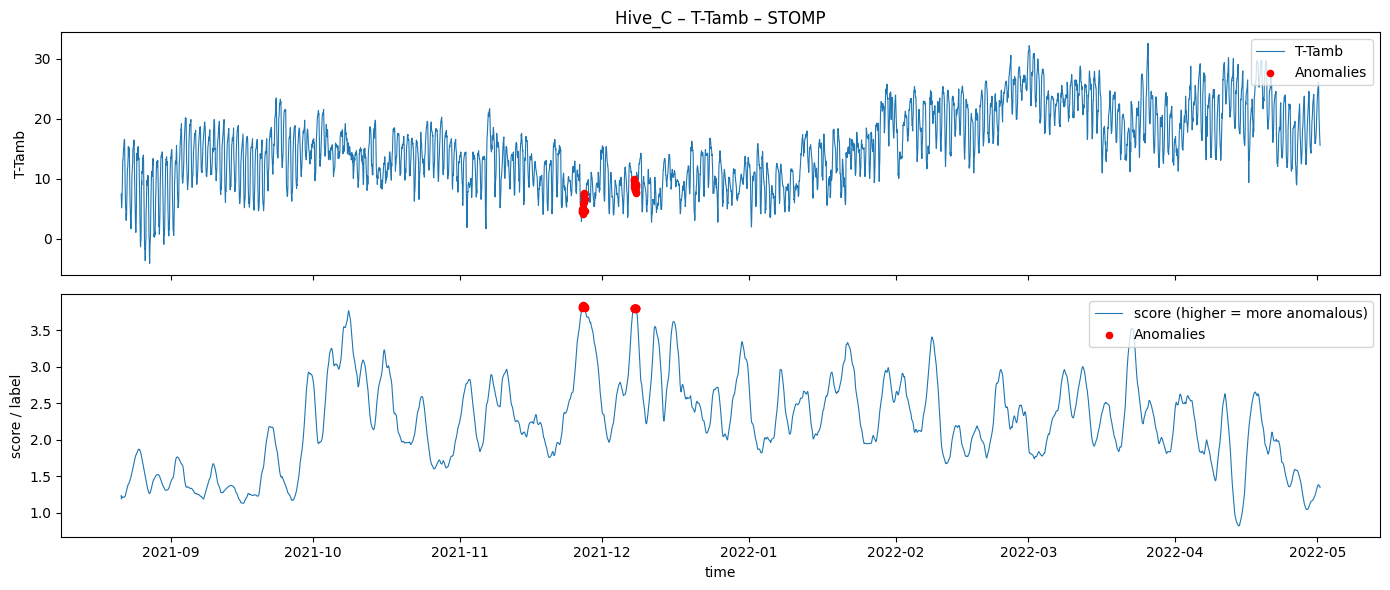

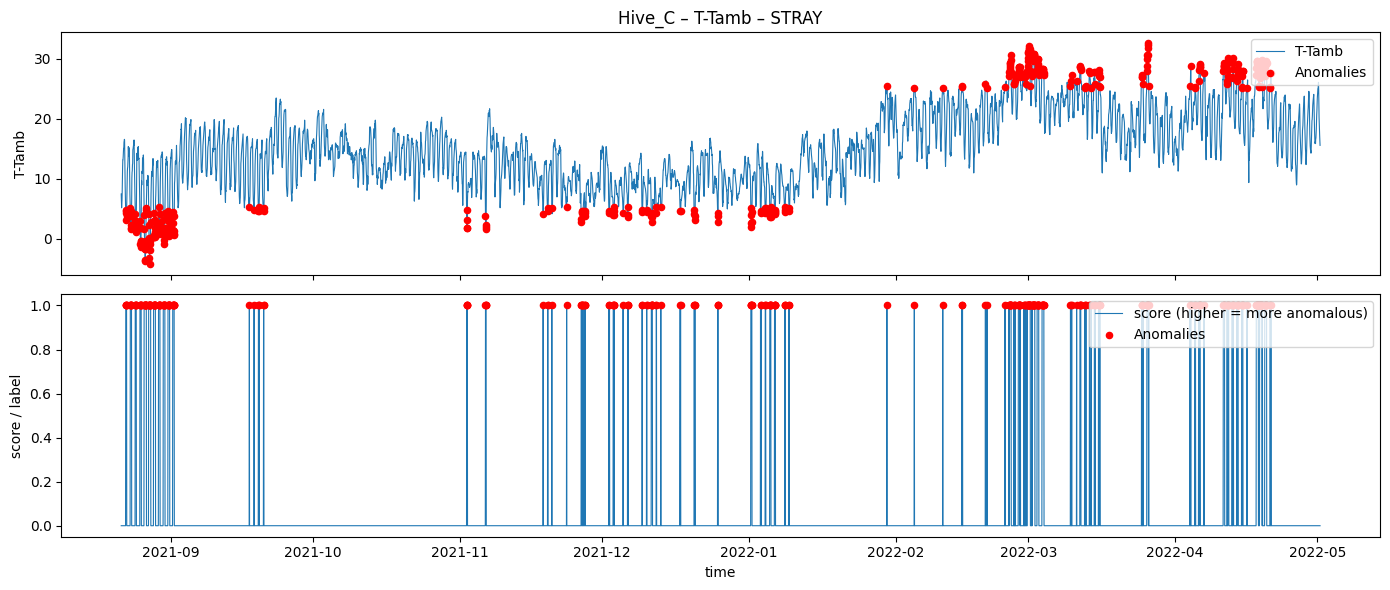

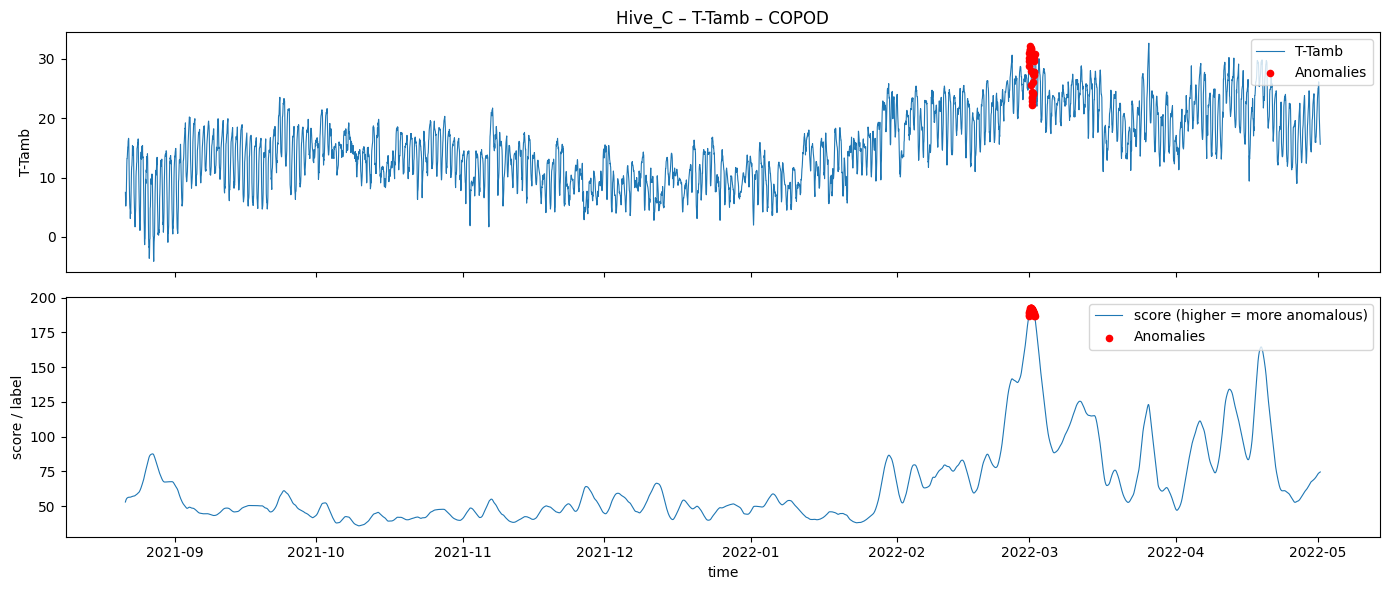

c:\Users\janav\Documents\projects\xai-sandbox\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:4671: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
c:\Users\janav\Documents\projects\xai-sandbox\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:4671: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


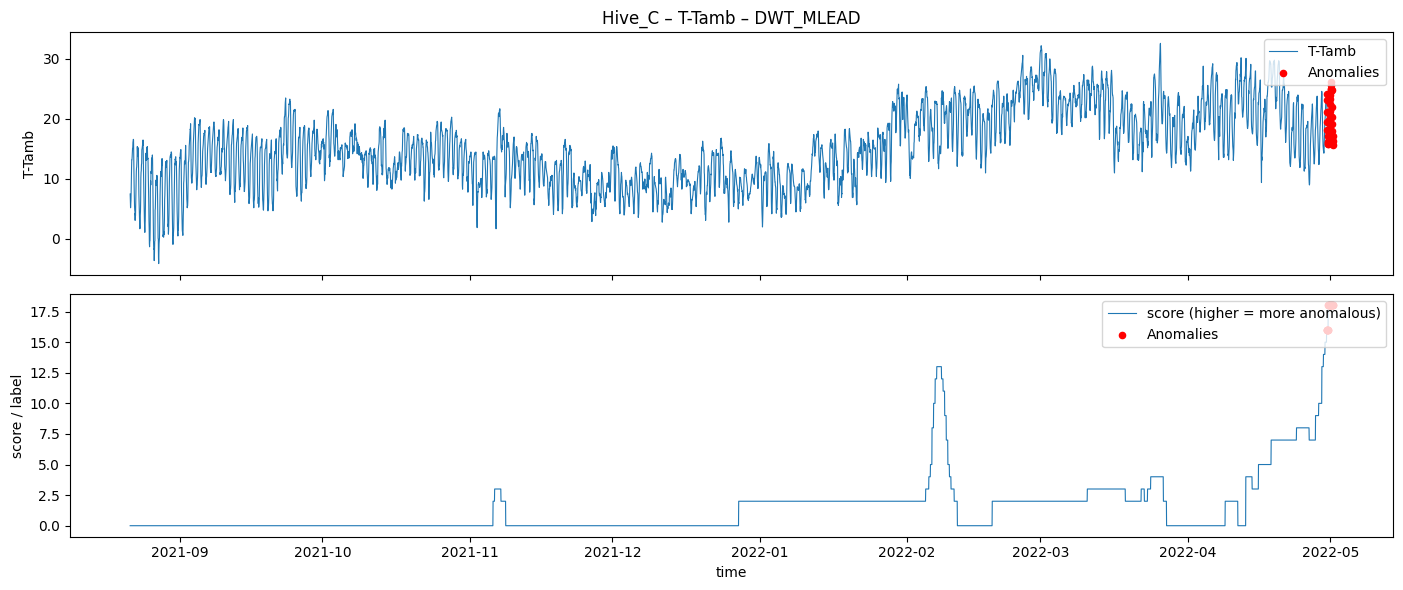

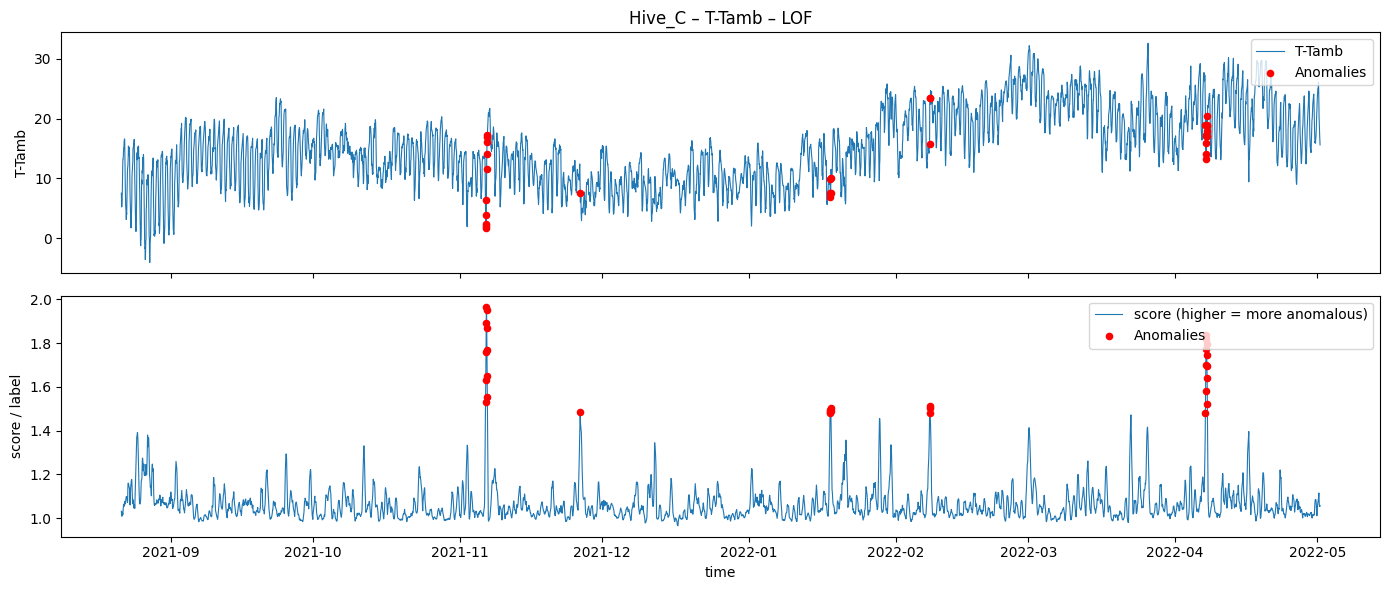

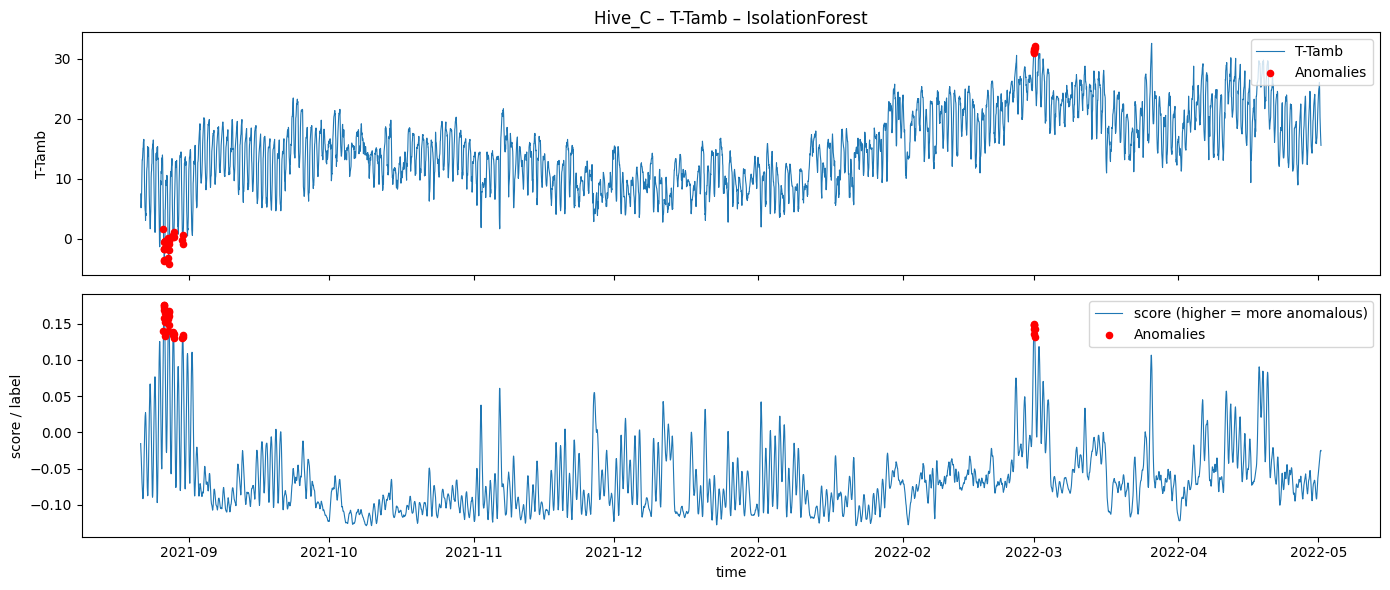

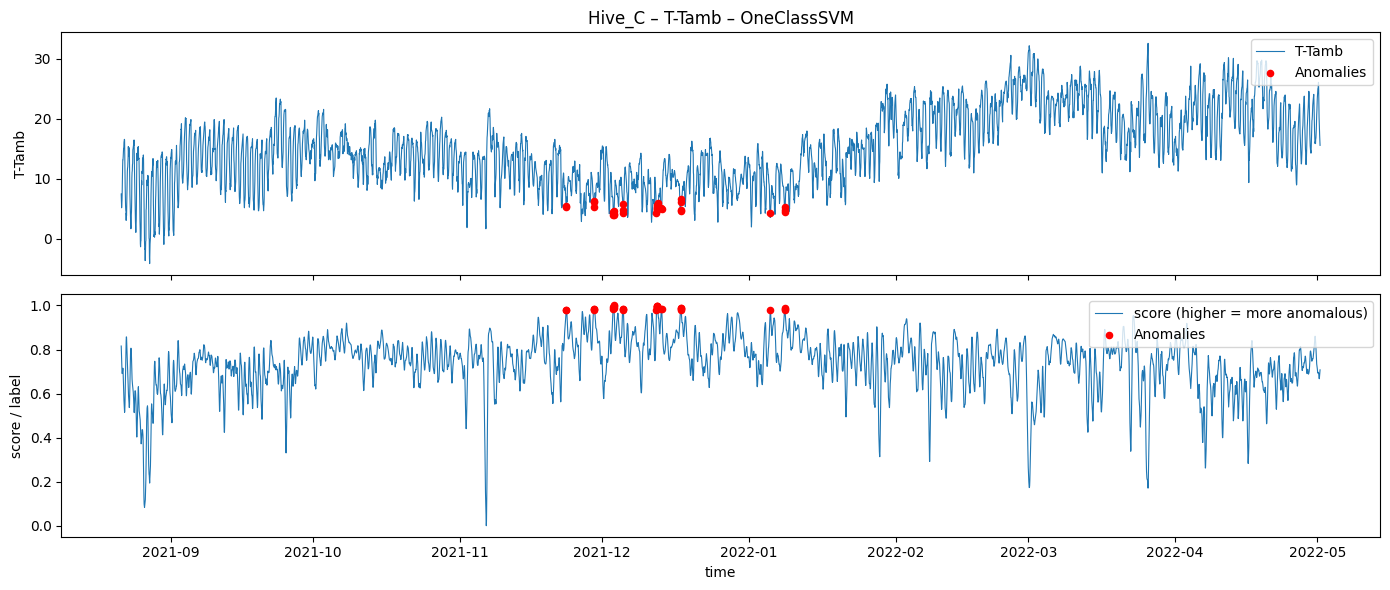

In [15]:
# Examples on Hive_A temperature "T"
hive_name = "Hive_C"
df_hive = hives[hive_name]

# 1) STOMP: matrix-profile based subsequence anomaly scores
scores_stomp, labels_stomp = run_aeon_detector_on_hive(
    hive_name,
    df_hive,
    col="T-Tamb",
    detector=STOMP(window_size=48),
    top_k=30,
)

# 2) STRAY: robust outlier detection (direct 0/1 labels)
scores_stray, labels_stray = run_aeon_detector_on_hive(
    hive_name,
    df_hive,
    col="T-Tamb",
    detector=STRAY(),
    top_k=30,  # only used if it returns scores, here labels are direct
)

# 3) COPOD: copula-based detector on sliding windows
scores_copod, labels_copod = run_aeon_detector_on_hive(
    hive_name,
    df_hive,
    col="T-Tamb",
    detector=COPOD(window_size=48, stride=1),
    top_k=30,
)

# 4) DWT_MLEAD: wavelet-based anomaly detector
scores_dwt, labels_dwt = run_aeon_detector_on_hive(
    hive_name,
    df_hive,
    col="T-Tamb",
    detector=DWT_MLEAD(),
    top_k=30,
)

# 5) LOF wrapper
scores_lof, labels_lof = run_aeon_detector_on_hive(
    hive_name,
    df_hive,
    col="T-Tamb",
    detector=LOF(n_neighbors=20),
    top_k=30,
)

# 6) IsolationForest wrapper
scores_if, labels_if = run_aeon_detector_on_hive(
    hive_name,
    df_hive,
    col="T-Tamb",
    detector=IsolationForest(),
    top_k=30,
)

# 7) OneClassSVM wrapper
scores_oc, labels_oc = run_aeon_detector_on_hive(
    hive_name,
    df_hive,
    col="T-Tamb",
    detector=OneClassSVM(nu=0.01, kernel="rbf"),
    top_k=30,
)
